In [1]:
%load_ext autoreload
%autoreload 2
# set up Python environment: numpy for numerical routines, and matplotlib for plotting
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# display plots in this notebook
%matplotlib inline
import os
import h5py
from natsort import natsorted, ns
from glob import glob

import ipywidgets as widgets
from IPython.display import display

from utils import get_save_button

from sklearn.metrics import confusion_matrix
from utils import classification_report

# Fixed paths
base_local = os.path.expanduser('~/Documents/Results')
base_rbr = os.path.expanduser('~/rbr_cnn/rtracker_caffe')

local_net_path = os.path.join(base_rbr,'net')
local_data_ap_path = os.path.join(base_rbr,'data')
local_data_mo_path = os.path.join(base_rbr,'data_flow_norm')

In [37]:
folders = sorted(os.listdir(base_local), reverse=True)
sel_folder_ap = widgets.Select(description='Results folder appearance:', options=folders)
sel_folder_mo = widgets.Select(description='Results folder motion:', options=folders)

def get_sub_folders(folder, basepath=''):
    return ['.'] + map(lambda p: os.path.basename(os.path.dirname(p)), sorted(glob(os.path.join(basepath, folder, '*/'))))

def update_sub_folders_1(arg):
    sel_sub_folder_ap.options = get_sub_folders(arg['new'], base_local)
    
def update_sub_folders_2(arg):
    sel_sub_folder_mo.options = get_sub_folders(arg['new'], base_local)

sel_sub_folder_ap = widgets.Select(description='Sub folder appearance:', options=get_sub_folders(folders[0], base_local))
sel_sub_folder_mo = widgets.Select(description='Sub folder motion:', options=get_sub_folders(folders[0], base_local))

display(widgets.VBox([widgets.HBox([sel_folder_ap, sel_sub_folder_ap]),
                      widgets.HBox([sel_folder_mo, sel_sub_folder_mo])]))

sel_folder_ap.observe(update_sub_folders_1, names='value')
sel_folder_mo.observe(update_sub_folders_2, names='value')

In [38]:
def get_indexed_data(local_data_path, local_log_path):
    
    # If true, load the video/frame index from the aux data (test.txt) or (test_set.txt if shuffled), 
    #  so that we can assign predictions to their proper video segments. This is also used in case the test set is shuffled 
    #  and to remove duplicate predictions due to batch processing.
    # Set only to False if you are sure you know why you do it!
    use_proper_index = True

    # load labels
    labels_file = os.path.join(local_data_path, 'labels.txt')
    label_set = np.loadtxt(labels_file, str, delimiter='\t')

    # load predictions
    probs = []
    labels = []
    with h5py.File(os.path.join(local_log_path, 'test_probs.h5'),'r') as fh:    
        for key in natsorted(fh.keys(), alg=ns.IGNORECASE):
            if key.startswith('label'):
                labels.append(fh[key][()])
            else:
                probs.append(fh[key][()])

    probs = np.vstack(probs).squeeze()
    labels = np.vstack(labels).squeeze().astype(int)

    # labels used
    used_labels = sorted(np.unique(labels))
    label_set = label_set[used_labels]

    pred = np.argmax(probs[:, used_labels], axis=1)

    if use_proper_index:
        # Merge predictions with proper index
        set_file = os.path.join(local_data_path, 'test_index.txt')
        if not os.path.isfile(set_file):
            set_file = os.path.join(local_data_path, 'test.txt')
            print 'Using default test set index.'
        else:
            print 'Using de-randomized test set index.'

        # peek inside
        ncols = pd.read_csv(set_file, sep=' ', header=None, nrows=1).shape[1]
        if ncols == 2:
            # standard <image> <label> format
            df = pd.read_csv(set_file, sep=' ', header=None, names=['image', 'label'])
            # convert image path to video name and frame number
            df['video'] = df['image'].apply(lambda p: os.path.basename(os.path.dirname(p)))
            df['frame'] = df['image'].apply(lambda p: int(os.path.splitext(os.path.basename(p))[0].split('_')[-1]))
            df = df.drop('image', axis=1)

        elif ncols == 3:
            # C3D format: <folder> <start_frame> <label>
            df = pd.read_csv(set_file, sep=' ', header=None, names=['video', 'frame', 'label'])

        else:
            raise TypeError('Unknown index format. Neither 2 nor 3 column format.')

        df = df.set_index(['video', 'frame'])

        # check if results are shuffled
        if not (df['label'].iloc[:50] == labels[:50]).all():
            print 'Result is shuffled. Cannot align results properly. Using randomized results.'
            df = pd.DataFrame(pred[:df.shape[0]], columns=['label'])  # new dataframe without index
            df['pred'] = pred[:df.shape[0]] # copy predictions
            dfprobs = pd.DataFrame(index=df.index, data=probs[:df.shape[0], :])  
        else:
            # sanity check, size test set and predictions are unequal due to batch processing;
            # the additional prediction should be equal to the first predictions (batch processing start from beginning again)
            overlap_test = pred.shape[0] - df.shape[0]

            if not (pred[:overlap_test] == pred[-overlap_test:]).all():
                raise ValueError('Predictions invalid. Are they shuffled?')

            df['pred'] = pred[:df.shape[0]] # copy predictions
            dfprobs = pd.DataFrame(index=df.index, data=probs[:df.shape[0], :])

            df = df.sortlevel(0)
            dfprobs = dfprobs.sortlevel(0)
    else:
        df = pd.DataFrame(np.vstack([labels, pred]).T, columns=['label', 'pred'])
        dfprobs = pd.DataFrame(index=df.index, data=probs)
    
    return df, dfprobs, label_set, used_labels

In [39]:
model_path = {}
log_path = {}
model_path['img'] = os.path.join(base_local, sel_folder_ap.value, sel_sub_folder_ap.value)
model_path['flow'] = os.path.join(base_local, sel_folder_mo.value, sel_sub_folder_mo.value)
log_path['img'] = os.path.join(base_local, sel_folder_ap.value, sel_sub_folder_ap.value)
log_path['flow'] = os.path.join(base_local, sel_folder_mo.value, sel_sub_folder_mo.value)

df = {}
dfprobs = {}

d, p, label_set, used_labels = get_indexed_data(local_data_ap_path, log_path['img'])
df['img'] = d
dfprobs['img'] = p

d, p, label_set, used_labels = get_indexed_data(local_data_mo_path, log_path['flow'])
df['flow'] = d
dfprobs['flow'] = p

df = pd.concat(df, axis=1).sortlevel(0)
dfprobs = pd.concat(dfprobs, axis=1).sortlevel(0)

# fill temporal stride
df = df.fillna(method='ffill').astype(int)

dfprobs = dfprobs.fillna(method='ffill')
dfprobs = dfprobs.rolling(10, min_periods=1, center=True, win_type='boxcar').mean()

Using de-randomized test set index.
Using default test set index.


In [40]:
df.head()

flow        img     
                    label pred label pred
video         frame                      
Observation07 1         1    4     1    0
              2         1    4     1    0
              3         1    4     1    4
              4         1    4     1    4
              5         1    4     1    4

In [41]:
for model in df.columns.get_level_values(0).unique():
    print '------'
    print model
    print '------'
    print classification_report(df[(model, 'label')], df[(model, 'pred')], labels=used_labels, target_names=label_set)

------
flow
------
             precision    recall  f1-score   support

Approaching       0.17      0.30      0.22      3850
    Contact       0.49      0.66      0.56     11385
  Following       0.26      0.30      0.27      2445
Moving away       0.07      0.10      0.09      1790
   Solitary       0.82      0.58      0.68     25987

avg / total       0.62      0.54      0.57     45457
avg / class       0.36      0.39      0.36         5

------
img
------
             precision    recall  f1-score   support

Approaching       0.20      0.27      0.23      3787
    Contact       0.63      0.73      0.68     11328
  Following       0.25      0.34      0.29      2461
Moving away       0.10      0.29      0.15      1812
   Solitary       0.92      0.65      0.76     26069

avg / total       0.72      0.61      0.65     45457
avg / class       0.42      0.46      0.42         5



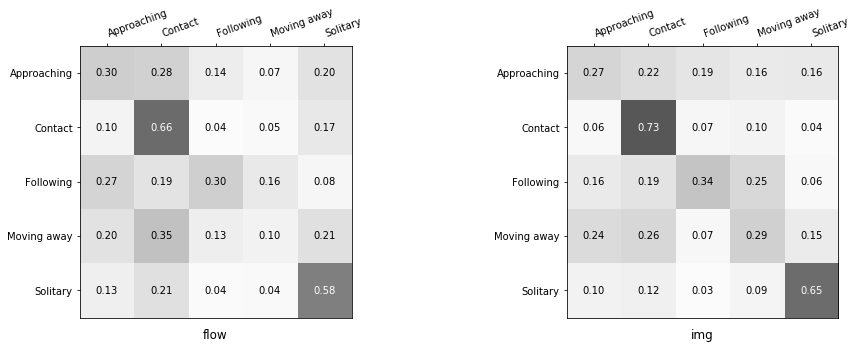

In [42]:
plt.rcParams['figure.facecolor'] = 'w'

fig, axs = plt.subplots(1, len(model_path), figsize=(16,5))

for i, model in enumerate(df.columns.get_level_values(0).unique()):
    cm = confusion_matrix(df[(model, 'label')], df[(model, 'pred')])
    cm = cm / cm.sum(axis=1, dtype=float, keepdims=True)  # precision

    # show matrix
    ax = axs.flat[i]
    cmimg = ax.matshow(cm, cmap='Greys', vmin=0, vmax=1)

    # show labels
    ax.set_xticklabels([''] + label_set.tolist(), rotation=20, ha='left');
    ax.set_yticklabels([''] + label_set.tolist(), ha='right');
    ax.tick_params(bottom=False)
    ax.set_title(model, y=-0.1)

    # print values in cells
    hide_threshold=0.005
    annot_fmt = '{0:.2f}'
    colorvalues = np.mean(cmimg.to_rgba( cm )[:,:,0:3], axis=-1)
    you_have_been_warned = False
    for i in xrange(cm.shape[0]):
        for j in xrange(cm.shape[1]):
            if cm[i,j] < hide_threshold:
                continue
            ax.annotate(annot_fmt.format(cm[i,j]), xy=(j, i), 
                        horizontalalignment='center', verticalalignment='center', 
                        color= 'k' if colorvalues[i,j] > .5 else 'w')
        
#display(get_save_button(fig, os.path.join(local_log_path, 'confusion_matrix.png')))

In [43]:
print 'Both models predict the same:', (df[('flow', 'pred')] == df[('img', 'pred')]).sum() / float(df.shape[0])

Both models predict the same: 0.597839716655


In [44]:
img_true_mask = df[('img', 'pred')] == df[('img', 'label')]
flow_true_mask = df[('flow', 'pred')] == df[('flow', 'label')]


print 'Given true pred by img, how often is flow true as well:',\
    (df.loc[img_true_mask, ('img', 'pred')] == df.loc[img_true_mask, ('flow', 'pred')]).sum() / float(img_true_mask.sum())
    
print 'Given true pred by flow, how often is img true as well:',\
    (df.loc[flow_true_mask, ('img', 'pred')] == df.loc[flow_true_mask, ('flow', 'pred')]).sum() / float(flow_true_mask.sum())

all_true_mask = img_true_mask & flow_true_mask
either_true_mask = img_true_mask | flow_true_mask

print 'Where both are correct:', all_true_mask.sum() / float(df.shape[0])
print 'Where at least one is correct:', either_true_mask.sum() / float(df.shape[0])

Given true pred by img, how often is flow true as well: 0.734947170358
Given true pred by flow, how often is img true as well: 0.827160996256
Where both are correct: 0.444442000132
Where at least one is correct: 0.704071980113


In [45]:
def plot_confusion_matrix(a, b, norm=False):
    plt.rcParams['figure.facecolor'] = 'w'

    cm = confusion_matrix(a, b)
    if norm:
        cm = cm / cm.sum(axis=1, dtype=float, keepdims=True)  # precision

    # show matrix
    cmimg = plt.matshow(cm, cmap='Greys', vmin=0)#, vmax=1)
    ax = plt.gca()

    # show labels
    ax.set_xticklabels([''] + label_set.tolist(), rotation=20, ha='left');
    ax.set_yticklabels([''] + label_set.tolist(), ha='right');
    ax.tick_params(bottom=False)

    # print values in cells
    hide_threshold=0.005
    annot_fmt = '{0:.2f}'
#     annot_fmt = '{:d}'
    colorvalues = np.mean(cmimg.to_rgba( cm )[:,:,0:3], axis=-1)
    you_have_been_warned = False
    for i in xrange(cm.shape[0]):
        for j in xrange(cm.shape[1]):
            if cm[i,j] < hide_threshold:
                continue
            ax.annotate(annot_fmt.format(cm[i,j]), xy=(j, i), 
                        horizontalalignment='center', verticalalignment='center', 
                        color= 'k' if colorvalues[i,j] > .5 else 'w')

    #display(get_save_button(fig, os.path.join(local_log_path, 'confusion_matrix.png')))

If IMG is correct, what does flow predict?


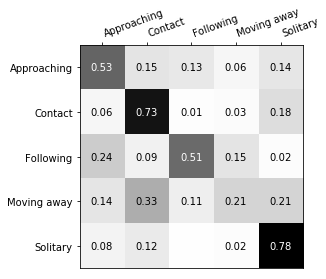

In [46]:
print 'If IMG is correct, what does flow predict?'
plot_confusion_matrix(df.loc[img_true_mask, ('img', 'pred')], df.loc[img_true_mask, ('flow', 'pred')], norm=True)

If flow is correct, what does IMG predict?


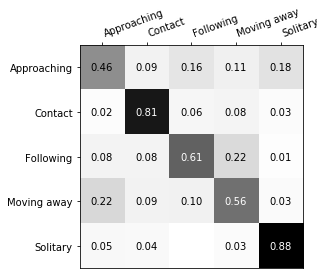

In [47]:
print 'If flow is correct, what does IMG predict?'
plot_confusion_matrix(df.loc[flow_true_mask, ('flow', 'pred')], df.loc[flow_true_mask, ('img', 'pred')], norm=True)

             precision    recall  f1-score   support

Approaching       0.21      0.32      0.26      3787
    Contact       0.61      0.79      0.69     11328
  Following       0.29      0.34      0.31      2461
Moving away       0.12      0.24      0.16      1812
   Solitary       0.93      0.65      0.77     26069

avg / total       0.72      0.63      0.66     45457
avg / class       0.43      0.47      0.44         5



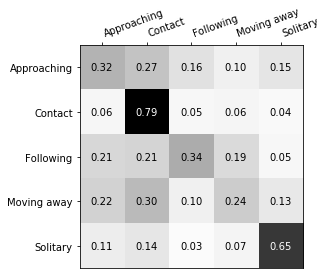

In [57]:
## PROB FUSION
w = [.75, .25]
dffused = w[0] * dfprobs['img'] + w[1] * dfprobs['flow']

print classification_report(df[('img', 'label')], dffused.idxmax(axis=1), 
                            labels=used_labels, target_names=label_set)


plot_confusion_matrix(df[('img', 'label')], dffused.idxmax(axis=1), norm=True)